In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from datetime import datetime, timedelta

from configs.base_config import TrainingModuleConfig
from configs.base_config import ModelEvaluatorConfig

from modules.data_fetcher_module import DataFetcherModule
from modules.forecasting_module import ForecastingModule
from configs.base_config import ForecastingModuleConfig
from modules.model_evaluator import ModelEvaluator
from modules.training_module import TrainingModule

In [2]:
with open('train_config.json') as f_train, \
    open('test_config.json') as f_test, \
    open('forecast_config.json') as f_forecast:
    default_train_config = json.load(f_train)
    default_test_config = json.load(f_test)
    default_forecast_config = json.load(f_forecast)

In [3]:
def parse_params(parameters, interval='Train1'):
    """
        Flatten the params dictionary to enable logging
    of the parameters.
    
    Assumptions:
        There is a maximum of one level of nesting.
        Ensured using an assert statement for now.
        
    Sample_input:
        {
            'LatentEbyCRatio': {
                '4/7/20': 0.5648337712691847,
                '4/17/20': 1.1427545912005197
            },
            'LatentIbyCRatio': {
                '4/7/20': 0.9610881623714099,
                '4/17/20': 0.6742970940209254
            }
        }
    
    Output:
        {
            'Train1_LatentEbyCRatio_4/7/20': 0.5648337712691847,
            'Train1_LatentEbyCRatio_4/17/20': 1.1427545912005197,
            'Train1_LatentIbyCRatio_4/7/20': 0.9610881623714099,
            'Train1_LatentIbyCRatio_4/17/20': 0.6742970940209254
        }
    """
    param_dict = dict() # The flattened dictionary to return
    for param in parameters:
        if isinstance(parameters[param], dict):
            for key in parameters[param]:
                assert (not isinstance(parameters[param][key], dict))
                
                param_dict[interval + '_' + param + '_'+ key] = parameters[param][key]
        else:
            param_dict[interval + '_' + param] = parameters[param]
    return param_dict

In [4]:
def train_eval(region, region_type, 
               train1_start_date, train1_end_date, 
               train2_start_date, train2_end_date, run_day,
               test_start_date, test_end_date, max_evals = 1000, 
               data_source = None, mlflow_log = True, name_prefix = None):
    """
        #TODO: Need to add hooks to consume data from appropriate source

        Run train and evalation for (basic) SEIR model.
    
    Arguments:
        region, region_type : Region info corresponding to the run
        train1_start_date, train1_end_date : Train1 durations
        train2_start_date, train2_end_date : Train2 durations
        test_start_date, test_end_date, run_day : Test durations
        max_evals : number of search evaluations for SEIR (default: 1000)
        data_source : Data source for picking the region data
        mlflow_log : Experiment logged using MLFlow (default: True)
        name_prefix : In case of non-MLFlow experiment, string prefix to
                      enable easy indexing of experiments

    Note:
        date_format : %-m/%-d/%-y

    Returns: 
        params : Run parameters to be logged
        metrics : Metrics collected from the run 
    
    Output files saved : (name_prefix added in the case of non-MLflow experiments)
        Train1 : train1_output.json (name_prefix + '_train1_output.json')
        Train2 : train2_output.json (name_prefix + '_train2_output.json')
        Test   : test_output.json   (name_prefix + '_test_output.json')
    """
    
    # Save metrics and params for logging
    params = dict()
    metrics = dict()

    params['region'] = region
    params['region_type'] = region_type
    params['train1_start_date'] = train1_start_date
    params['train1_end_date'] = train1_end_date
    params['train2_start_date'] = train2_start_date
    params['train2_end_date'] = train2_end_date
    params['run_day'] = run_day
    params['test_start_date'] = test_start_date
    params['test_end_date'] = test_end_date
    params['data_source'] = data_source
    
    # model parameters
    model_params = dict()
    model_params['region'] = region
    model_params['region_type'] = region_type
    model_params['model_type'] = "SEIR"
    

    train_config = deepcopy(default_train_config)
    train_config['region_name'] = region
    train_config['region_type'] = region_type
    train_config['train_start_date'] = train1_start_date
    train_config['train_end_date'] = train1_end_date
    train_config['search_parameters']['max_evals'] = max_evals
    
    if mlflow_log:
        train_config['output_filepath'] = 'train1_output.json'
    else:
        assert name_prefix is not None
        train_config['output_filepath'] = name_prefix + '_train1_output.json'

    train_module_config = TrainingModuleConfig.parse_obj(train_config)
    trainResults = TrainingModule.from_config(train_module_config)
    
    metrics['Train1MAPE'] = trainResults['train_metric_results'][0]['value']
    metrics['Train1RMLSE'] = trainResults['train_metric_results'][1]['value']
    metrics.update(parse_params(trainResults['best_params'], 'Train1'))
    metrics.update(parse_params(trainResults['latent_params'], 'Train1')) 
    
    test_config = deepcopy(default_test_config)
    test_config['region_name'] = region
    test_config['region_type'] = region_type
    test_config['test_start_date'] = test_start_date
    test_config['test_end_date'] = test_end_date
    test_config['run_day'] = run_day
    test_config['model_parameters'].update(trainResults['best_params'])    
    test_config['model_parameters'].update(trainResults['latent_params'])  
        
    if mlflow_log:
        test_config['output_filepath'] = 'test_output.json'
    else:
        test_config['output_filepath'] = name_prefix + '_test_output.json'

    test_module_config = ModelEvaluatorConfig.parse_obj(test_config) 
    evalResults = ModelEvaluator.from_config(test_module_config)
    
    metrics['TestMAPE'] = evalResults[0]['value']
    metrics['TestRMLSE'] = evalResults[1]['value']
    
    
    finalTrain_config = deepcopy(default_train_config)
    finalTrain_config['region_name'] = region
    finalTrain_config['region_type'] = region_type
    finalTrain_config['train_start_date'] = train2_start_date
    finalTrain_config['train_end_date'] = train2_end_date
    finalTrain_config['search_parameters']['max_evals'] = max_evals
    
    if mlflow_log:
        finalTrain_config['output_filepath'] = 'train2_output.json'
    else:
        finalTrain_config['output_filepath'] = name_prefix + '_train2_output.json'

    finalTrain_module_config = TrainingModuleConfig.parse_obj(finalTrain_config)
    finalResults = TrainingModule.from_config(finalTrain_module_config)
    
    metrics['Train2MAPE'] = finalResults['train_metric_results'][0]['value']
    metrics['Train2RMLSE'] = finalResults['train_metric_results'][1]['value']
    metrics.update(parse_params(finalResults['best_params'], 'Train2'))
    metrics.update(parse_params(finalResults['latent_params'], 'Train2'))
        
    model_params['model_parameters'] = dict()
    model_params['model_parameters'].update(finalResults['best_params'])
    model_params['model_parameters'].update(finalResults['latent_params'])
    model_params['model_parameters']['MAPE'] = finalResults['train_metric_results'][0]['value']
    
    return params, metrics, model_params

# Parameter Override

In [8]:
def override_parameters(model_params, param_override):
    """
        Enable overriding of SEIR model parameters.
        
    Arguments:
        model_params   : Original SEIR model params. Note that the 
                         expected format is the same as the one 
                         shared with the backend API.
        param_override : Dictionary of parameters and new values 
                         for overriding.
    
    Returns:
        model_params : Updated model_params. Note that we make a deepcopy of the
                       model_param dictionary.

    Example:
    model_params =  {'region': 'mumbai',
                     'region_type': 'district',
                     'model_type': 'SEIR',
                     'model_parameters': {'EbyCRatio': 0.5369542220931649,
                      'IbyCRatio': 0.877531106686125,
                      'infectious_period': 5.031419911631426,
                      'r0': 0.5169788535587769,
                      'LatentEbyCRatio': {'4/12/20': 0.5369542220931649,
                       '4/22/20': 0.1780890696175734},
                      'LatentIbyCRatio': {'4/12/20': 0.877531106686125,
                       '4/22/20': 0.2511722686138453},
                      'MAPE': 8.768146390596282,
                      'incubation_period': 5}}
    param_override = {'r0': 1.1, 'incubation_period' : 3}
    
    Return:
    model_params =  {'region': 'mumbai',
                     'region_type': 'district',
                     'model_type': 'SEIR',
                     'model_parameters': {'EbyCRatio': 0.5369542220931649,
                      'IbyCRatio': 0.877531106686125,
                      'infectious_period': 5.031419911631426,
                      'r0': 1.1,
                      'LatentEbyCRatio': {'4/12/20': 0.5369542220931649,
                       '4/22/20': 0.1780890696175734},
                      'LatentIbyCRatio': {'4/12/20': 0.877531106686125,
                       '4/22/20': 0.2511722686138453},
                      'MAPE': 8.768146390596282,
                      'incubation_period': 3}}
    """
    
    # Ensure that the original dictionary remains unaltered
    updated_params = deepcopy(model_params)
    param_dict = updated_params['model_parameters']
    
    # Additional sanity check for keys in param_override
    # Check if the param_override dict contains only
    # valid keys from the model parameters
    model_keys = set(param_dict.keys())
    override_keys = set(param_override.keys())
    
    # Assert that the keys in override are a subset of the 
    # keys in the original model parameters
    assert not (override_keys - model_keys)
    
    
    # Override the parameters
    param_dict.update(param_override)
    
    return updated_params

In [9]:
model_params =  {'region': 'mumbai',
                 'region_type': 'district',
                 'model_type': 'SEIR',
                 'model_parameters': {'EbyCRatio': 0.5369542220931649,
                  'IbyCRatio': 0.877531106686125,
                  'infectious_period': 5.031419911631426,
                  'r0': 0.5169788535587769,
                  'LatentEbyCRatio': {'4/12/20': 0.5369542220931649,
                   '4/22/20': 0.1780890696175734},
                  'LatentIbyCRatio': {'4/12/20': 0.877531106686125,
                   '4/22/20': 0.2511722686138453},
                  'MAPE': 8.768146390596282,
                  'incubation_period': 5}}
param_override = {'r0': 1.1, 'incubation_period' : 3}
updated_params = override_parameters(model_params, param_override)

In [10]:
updated_params

{'region': 'mumbai',
 'region_type': 'district',
 'model_type': 'SEIR',
 'model_parameters': {'EbyCRatio': 0.5369542220931649,
  'IbyCRatio': 0.877531106686125,
  'infectious_period': 5.031419911631426,
  'r0': 1.1,
  'LatentEbyCRatio': {'4/12/20': 0.5369542220931649,
   '4/22/20': 0.1780890696175734},
  'LatentIbyCRatio': {'4/12/20': 0.877531106686125,
   '4/22/20': 0.2511722686138453},
  'MAPE': 8.768146390596282,
  'incubation_period': 3}}

In [11]:
model_params

{'region': 'mumbai',
 'region_type': 'district',
 'model_type': 'SEIR',
 'model_parameters': {'EbyCRatio': 0.5369542220931649,
  'IbyCRatio': 0.877531106686125,
  'infectious_period': 5.031419911631426,
  'r0': 0.5169788535587769,
  'LatentEbyCRatio': {'4/12/20': 0.5369542220931649,
   '4/22/20': 0.1780890696175734},
  'LatentIbyCRatio': {'4/12/20': 0.877531106686125,
   '4/22/20': 0.2511722686138453},
  'MAPE': 8.768146390596282,
  'incubation_period': 5}}

# Intervention to model map

### Model the impact of the following interventions
* Testing rate
* Fraction of population in containment
* Fraction of population wearing masks

### High level overview of mapping interventions to model parameters
Each of the 3 interventions from above impact the virus dynamics which can be tied to model parameters.

Current assumptions on the impact of each of the interventions
r0 - goes down with increasing fraction of mask wearing population and containment
incubation_period - goes down with increased testing
infectious_period - goes down with more testing and containment (more isolation)

Interventions are specifed as a dictionary
```
all_interventions = {‘testing_rate’: 0.5, ‘containment_fraction’: 0.4, ’mask_compliance’:0.9}
```

Interventions impact the parameters by linear scaling factors (Ignore the specific values)
```
scale_factor = {
    'MASK_R0_DROP' : 0.1,
    'CONTAINMENT_R0_DROP' : 0.2,
    'TESTING_TINC_DROP' : 0.3,
    'TESTING_TINF_DROP' : 0.4,
    'CONTAINMENT_TINF_DROP' : 0.5
}
```

The specific expression is specified as a dictionary to evaluate the change factor (WIP)
```
change_factor_map = {
    'testing_rate' : [('incubation_period' , lambda x : 1 - x * scale_factor['TESTING_TINC_DROP']), 
                      ('infectious_period' , lambda x : 1 - x * scale_factor['TESTING_TINF_DROP'])],
    'containment_fraction' : [('infectious_period' , lambda x : 1 - x * scale_factor['CONTAINMENT_TINF_DROP']),
                              ('r0' , lambda x : 1 - x * scale_factor['CONTAINMENT_R0_DROP'])],
    'mask_compliance' : [('r0' , lambda x : 1 - x * scale_factor['MASK_R0_DROP'])]
}
```

Say the intervention we apply is 
```
all_interventions = {'mask_compliance' : 0.9}
```

From the change factor map, we know that it impacts 'r0'.
Further, let the original 'r0' was 0.5

We compute the change_factor using the expression
change_factor = 1 - 0.9 * 0.1 = 0.91
The new 'r0' value will be = 0.91 * 0.5 = 0.455

## Scale factor

In [26]:
scale_factor = {
    'MASK_R0_DROP' : 0.1,
    'CONTAINMENT_R0_DROP' : 0.2,
    'TESTING_TINC_DROP' : 0.3,
    'TESTING_TINF_DROP' : 0.4,
    'CONTAINMENT_TINF_DROP' : 0.5
}

## Change factor map

In [13]:
change_factor_map = {
    'testing_rate' : [('incubation_period' , lambda x : 1 - x * scale_factor['TESTING_TINC_DROP']), 
                      ('infectious_period' , lambda x : 1 - x * scale_factor['TESTING_TINF_DROP'])],
    'containment_fraction' : [('infectious_period' , lambda x : 1 - x * scale_factor['CONTAINMENT_TINF_DROP']),
                              ('r0' , lambda x : 1 - x * scale_factor['CONTAINMENT_R0_DROP'])],
    'mask_compliance' : [('r0' , lambda x : 1 - x * scale_factor['MASK_R0_DROP'])]
}

## Compute individual change_factors

In [17]:
# TODO: Need to account for intervention impacting multiple parameters
def change_factors(all_interventions):
    param_change_factor = {}
    for intervention in all_interventions:
        factors = change_factor_map[intervention]
        level = all_interventions[intervention]
        for (param, expr) in factors:
            param_change_factor[param] = expr(level)
    return param_change_factor

## Compute model parameters on applying an intervention

In [19]:
def apply_intervention(model_paramters, all_interventions):
    """
        Update the SEIR model paramters based on the interventions
    applied.
    
    Arguments:
        model_parameters  : Original SEIR model params. Note that the 
                            expected format is the same as the one 
                            shared with the backend API. 
        all_interventions : Dictionary of interventions and levels of interventions
    
    Returns:
        updated_params    : Model paramters updated depending on the interventions
    """
    # Ensure that the original dictionary remains unaltered
    updated_params = deepcopy(model_params)
    param_dict = updated_params['model_parameters']

    param_change_factor = change_factors(all_interventions)
    for param in param_dict:
        p_val = param_dict[param]
        
        if param in param_change_factor:
            p_val = p_val*param_change_factor[param]
        
        # Update the parameters
        param_dict[param] = p_val
    
    return updated_params

## Sample intervention update

In [20]:
model_params =  {'region': 'mumbai',
                 'region_type': 'district',
                 'model_type': 'SEIR',
                 'model_parameters': {'EbyCRatio': 0.5369542220931649,
                  'IbyCRatio': 0.877531106686125,
                  'infectious_period': 5.031419911631426,
                  'r0': 0.5169788535587769,
                  'LatentEbyCRatio': {'4/12/20': 0.5369542220931649,
                   '4/22/20': 0.1780890696175734},
                  'LatentIbyCRatio': {'4/12/20': 0.877531106686125,
                   '4/22/20': 0.2511722686138453},
                  'MAPE': 8.768146390596282,
                  'incubation_period': 5}}
all_interventions = {'mask_compliance' : 0.9}
updated_params = apply_intervention(model_params, all_interventions)

In [21]:
updated_params

{'region': 'mumbai',
 'region_type': 'district',
 'model_type': 'SEIR',
 'model_parameters': {'EbyCRatio': 0.5369542220931649,
  'IbyCRatio': 0.877531106686125,
  'infectious_period': 5.031419911631426,
  'r0': 0.2843383694573273,
  'LatentEbyCRatio': {'4/12/20': 0.5369542220931649,
   '4/22/20': 0.1780890696175734},
  'LatentIbyCRatio': {'4/12/20': 0.877531106686125,
   '4/22/20': 0.2511722686138453},
  'MAPE': 8.768146390596282,
  'incubation_period': 5}}

In [22]:
model_params

{'region': 'mumbai',
 'region_type': 'district',
 'model_type': 'SEIR',
 'model_parameters': {'EbyCRatio': 0.5369542220931649,
  'IbyCRatio': 0.877531106686125,
  'infectious_period': 5.031419911631426,
  'r0': 0.5169788535587769,
  'LatentEbyCRatio': {'4/12/20': 0.5369542220931649,
   '4/22/20': 0.1780890696175734},
  'LatentIbyCRatio': {'4/12/20': 0.877531106686125,
   '4/22/20': 0.2511722686138453},
  'MAPE': 8.768146390596282,
  'incubation_period': 5}}

In [23]:
def forecast(model_params, run_day, forecast_start_date, forecast_end_date):
    evalConfig = ForecastingModuleConfig.parse_obj(default_forecast_config)
    evalConfig.region_name = model_params['region']
    evalConfig.region_type = model_params['region_type']
    evalConfig.model_parameters = model_params['model_parameters']

    evalConfig.run_day = run_day
    evalConfig.forecast_start_date = forecast_start_date
    evalConfig.forecast_end_date = forecast_end_date
    
    forecast_json = ForecastingModule.from_config(evalConfig)
    forecast_df = pd.read_json(forecast_json)
    forecast_df = forecast_df.drop(columns=['Region Type', 'Region', 'Country', 'Lat', 'Long'])
    forecast_df = forecast_df.set_index('prediction_type')
    forecast_df = forecast_df.transpose().reset_index()
    return forecast_df

In [32]:
def plot(model_params, run_day, forecast_start_date, forecast_end_date, 
         actual_start_date):
    forecast_df = forecast(model_params, run_day, forecast_start_date,
                           forecast_end_date)
    
    actual = DataFetcherModule.get_observations_for_region(model_params['region_type'], model_params['region'])
    actual = actual.set_index('observation')
    actual = actual.transpose()
    actual = actual.reset_index()
    start = actual.index[actual['index'] == actual_start_date].tolist()[0]
    actual = actual[start : ]
    
    fig, ax = plt.subplots(figsize=(15, 5))
    plt.title(model_params['region'])
    ax.plot(actual['index'], actual['confirmed'], color='green', label="observed")
    ax.plot(forecast_df['index'], forecast_df['confirmed_mean'], color='orange', label="predicted")
    plt.xticks(rotation=90)
    ax.set_ylim(ymin=0)
    ax.legend()
    fig.tight_layout()
    
    plt.show()

## Experiments

In [ ]:
region = 'mumbai'
region_type = 'district'
train1_start_date = '4/8/20'
train1_end_date = '4/17/20'
train2_start_date = '4/13/20'
train2_end_date = '4/22/20'
test_start_date = '4/18/20'
test_end_date = '4/22/20'
run_day = '4/17/20'

params, metrics, model_params = train_eval(region, region_type, 
                                           train1_start_date, train1_end_date, 
                                           train2_start_date, train2_end_date, run_day,
                                           test_start_date, test_end_date,
                                           max_evals = 500,
                                           mlflow_log = False,
                                           name_prefix = 'mumbai_sample')

In [28]:
model_params['model_parameters']['incubation_period'] = 5
model_params

{'region': 'mumbai',
 'region_type': 'district',
 'model_type': 'SEIR',
 'model_parameters': {'EbyCRatio': 0.5297531674095247,
  'IbyCRatio': 0.9212124060302807,
  'infectious_period': 1.5398025131259527,
  'r0': 2.1309347984734752,
  'LatentEbyCRatio': {'4/12/20': 0.5297531674095247,
   '4/22/20': 0.23150194425203788},
  'LatentIbyCRatio': {'4/12/20': 0.9212124060302807,
   '4/22/20': 0.07821218734327433},
  'MAPE': 4.096056565010594,
  'incubation_period': 5}}

t = 38.90


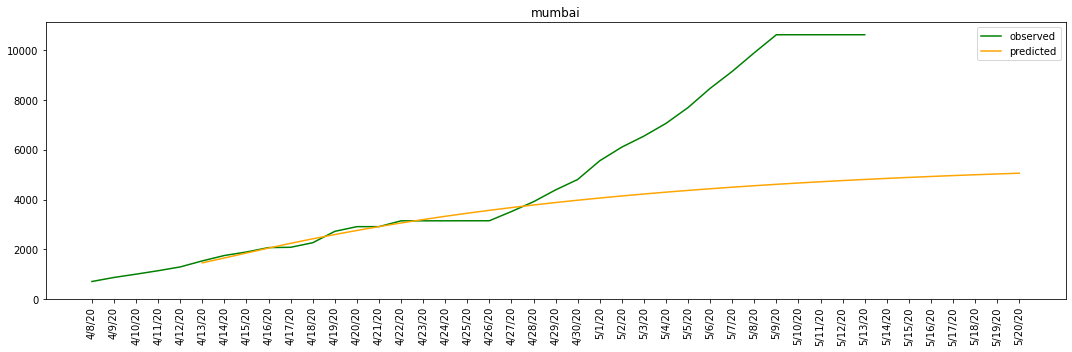

In [33]:
run_day = '4/12/20'
forecast_start_date = '4/13/20'
forecast_end_date = '5/20/20'
actual_start_date = '4/8/20'
plot(model_params, run_day, forecast_start_date, 
     forecast_end_date, actual_start_date)

## After paramter override

t = 38.90


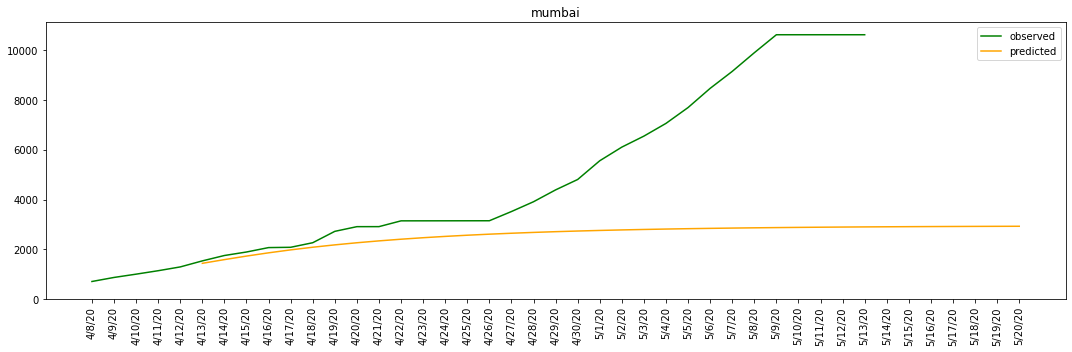

In [34]:
param_override = {'r0': 1.1}
updated_params = override_parameters(model_params, param_override)
run_day = '4/12/20'
forecast_start_date = '4/13/20'
forecast_end_date = '5/20/20'
actual_start_date = '4/8/20'
plot(updated_params, run_day, forecast_start_date, 
     forecast_end_date, actual_start_date)